In [1]:
!pip install qiskit
from qiskit import *

import torch
import torch.nn as nn

# Import from Qiskit Aer noise module
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

import numpy as np
import matplotlib

%matplotlib inline
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 735.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 2

In [2]:
def construct_noise(nqubits):
      
    noise = NoiseModel()

    ### ----------------- Bit-flip error ----------------- 
    # Error probabilities
    p_gate1_1qubit = 0.00031344
    p_gate1_2qubit = 0.0085165

    # QuantumError objects
    error_gate1 = pauli_error([('X',p_gate1_1qubit), ('I', 1 - p_gate1_1qubit)])
    error_gate2 = pauli_error([('X',p_gate1_2qubit), ('I', 1 - p_gate1_2qubit)])
    error_gate2 = error_gate2.tensor(error_gate2)

    ### ----------------- Thermal relaxation ----------------- 
    # T1 and T2 values for alll= qubits
    T1s = np.random.normal(153.404e3, 0, nqubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(62.028e3, 0, nqubits)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2*T1s[j]) for j in range(nqubits)])

    # Instruction times (in nanoseconds)
    time_sx = 35.55555555555556
    time_rz = 35.55555555555556
    time_cx = 368
    time_measure = 5351.111

    # QuantumError objects
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
    errors_sx = [thermal_relaxation_error(t1, t2, time_sx) for t1, t2 in zip(T1s, T2s)]
    errors_rz = [thermal_relaxation_error(t1, t2, time_rz) for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(thermal_relaxation_error(t1b, t2b, time_cx)) for t1a, t2a in zip(T1s, T2s)] for t1b, t2b in zip(T1s, T2s)]


    ### ----------------- Compose both noise models ----------------- 
    # Add errors to noise model
    for j in range(nqubits):
        noise.add_quantum_error(errors_measure[j], "measure", [j])
        noise.add_quantum_error(error_gate1.compose(errors_sx[j]), "sx", [j])
        noise.add_quantum_error(error_gate1.compose(errors_rz[j]), "rz", [j])
        for k in range(nqubits):
            noise.add_quantum_error(error_gate2.compose(errors_cx[j][k]), "cx", [j, k])

    return noise


def describe_qubit(gate, properties):
    us = 1e6
    ns = 1e9
    T1_avg = 0
    T2_avg = 0
    error_avg = 0
    length_avg = 0

    print("\nFor the", gate, "gate:\n")

    if gate == 'cx':
        n = 0
        for gate_i in props.gates:
            if 'cx' in gate_i.name:
                n += 1
                print(" - {0} gate on qubits {1} error rate is {2}\n"
                      " - Gate duration of {3} nanoseconds\n".format(gate_i.name, gate_i.qubits, gate_i.parameters[0].value, gate_i.parameters[1].value))
                error_avg += gate_i.parameters[0].value
                length_avg += gate_i.parameters[1].value
        print("The avg. gate error = {0}\n"
              "The avg. gate duration = {1} nanoseconds\n".format(error_avg/n, length_avg/n))

    else:
        n = config.n_qubits
        for i in range(n):
            print("Qubit {0} has a \n"
                  "  - T1 time of {1} microseconds\n"
                  "  - T2 time of {2} microseconds\n"
                  "  - Gate error of {3}\n"
                  "  - Gate duration of {4} nanoseconds\n"
                 .format(
                      i,
                      properties.t1(i) * us,
                      properties.t2(i) * us,
                      properties.gate_error(gate, i),
                      properties.gate_length(gate, i) * ns))
            T1_avg += properties.t1(i) * us
            T2_avg += properties.t2(i) * us
            error_avg += properties.gate_error(gate, i)
            length_avg += properties.gate_length(gate, i) * ns
        print("The avg. T1 time = {0} microseconds\n"
              "The avg. T2 time = {1} microseconds\n"
              "The avg. gate error = {2}\n"
              "The avg. gate duration = {3} nanoseconds\n".format(T1_avg/n, T2_avg/n, error_avg/n, length_avg/n))

In [3]:
real_qc = False
Noise = False
nqubits = 4**2

if real_qc:
    # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
    IBMQ.save_account("419a17d69588dfed5af2b2a3d64d1d2bc5875468a860b5ac07a06e520dda59e1eb248340a9ec91742c7773cad90a83a972744487a8e27045c62a16bce0af2367", overwrite=True) 
    provider = IBMQ.load_account()
    # Get backend for experiment
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend('ibmq_lima')
    
    config = backend.configuration()
    print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
          "{4} OpenPulse programs. The basis gates supported on this device are {5}."
          "".format(config.backend_name,
                    config.backend_version,
                    config.n_qubits,
                    '' if config.n_qubits == 1 else 's',
                    'supports' if config.open_pulse else 'does not support',
                    config.basis_gates))
    props = backend.properties()           
    describe_qubit('cx', props)
    
else:
    if Noise:
        noise = construct_noise(nqubits)
    else:
        noise = None
    backend = AerSimulator(noise_model=noise)

The minimum value of the Hamiltonian: -230.0620379453393 the configuration: 1111111111111111


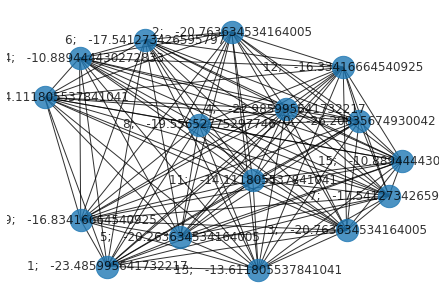

In [4]:
import networkx as nx
from itertools import combinations


def tsp_matrix_to_QUBO_matrix(w):
    n = len(w)
    Q = np.zeros((n*n, n*n))
    c = np.ones(n*n)
    A = np.max(w) * 3.85
    c = c * (-4*A)

    # k, l is the index of Q
    # i, j, p, p_ is the index of w
    for k in range(n*n):
        for l in range(n*n):
            i = k // n
            j = l // n
            p = k % n 
            p_ = l % n 
            if  (p+1)%n == p_:
                Q[k, l] = w[i, j] 
            elif p == p_ and i != j:
                Q[k, l] = Q[k, l] + A
            elif i == j and p != p_:
                Q[k, l] = Q[k, l] + A
            if k > l:
                Q[k, l] = 0

    return Q, c


def QUBO_to_Ising(Q, c):
    J = Q/4
    h = (c - np.sum(Q, axis=1))/2
    for i in range(len(h)):
        J[i][i] = h[i]

    return J


"""
Ising_coeff = [
            [0, 2, 3, 4],
            [0, 0, 8, 1],
            [0, 0, 0, 11],
            [0, 0, 0, 0]
        ]

Ising_coeff = [
            [1, 4],
            [0, 1]
        ]
"""

w = np.array([
      [0, 1, 2**0.5, 1],
      [0, 0, 1, 2**0.5],
      [0, 0, 0, 1],
      [0, 0, 0, 0]     
  ])


Q, c = tsp_matrix_to_QUBO_matrix(w)
Ising_coeff = QUBO_to_Ising(Q, c)
Ising_coeff = Ising_coeff.tolist()


# Visualize the connectivity of the Ising model
G = nx.Graph()
pairs = []
for i in range(0, nqubits):
    G.add_node(i, weight = Ising_coeff[i][i])
    for j in range(i+1, nqubits):
        pairs.append((i, j, Ising_coeff[i][j]))
G.add_weighted_edges_from(pairs)
labels = {n: str(n) + ';   ' + str(G.nodes[n]['weight']) for n in G.nodes}
nx.draw(G, with_labels=True, labels=labels, alpha=0.8, node_size=500)


# @jit(nopython=True, parallel=True, fastmath=True)
def H_Ising(bitstring, Ising_coeff):
    spins = []
    for bit in bitstring:
        if bit == '0':
            spins.append(-1)
        elif bit == '1':
            spins.append(1)
    H = 0
    for i in range(0, nqubits):
        H += Ising_coeff[i][i]*spins[i]
        for j in range(i+1, nqubits):
            H += Ising_coeff[i][j]*spins[i]*spins[j]
    return H


H_min = 10000
for i in range(2**len(Ising_coeff)):
    bitstring = np.binary_repr(i, nqubits)
    if H_Ising(bitstring, Ising_coeff) < H_min:
        H_min = H_Ising(bitstring, Ising_coeff)
        config_min = bitstring
print('The minimum value of the Hamiltonian:', H_min, 'the configuration:', config_min)

In [5]:


def compute_expectation(counts, Ising_coeff):   
    """
    Computes expectation value based on measurement results
    """   
    sum = 0
    sum_count = 0
    for bitstring, count in counts.items():
        sum += count*H_Ising(bitstring, Ising_coeff)
        sum_count += count
    return sum/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(Ising_coeff, theta): 
    """
    Creates a parametrized qaoa circuit
    """   
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(nqubits):
            for j in range(i+1, nqubits):
                if Ising_coeff != 0:
                    qc.rzz(2 * Ising_coeff[i][j]*gamma[irep], i, j)
        # mixer unitary
        for i in range(nqubits):
            qc.rz(2 * Ising_coeff[i][i]*gamma[irep], i)
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(theta):
    """
    Runs parametrized circuit and get expectation value
    
    """
    qc = create_qaoa_circ(Ising_coeff, theta)       
    qc = transpile(qc, backend=backend)
    if seed:
        seed_simulator = 10
    else:
        seed_simulator = None
    counts = backend.run(qc, seed_simulator=seed_simulator, nshots=shots).result().get_counts()       

    return compute_expectation(counts, Ising_coeff)

In [6]:
circuit = create_qaoa_circ(Ising_coeff, [1, 1])
circuit = transpile(circuit, backend=backend)
circuit.draw()

global phase: 3.1496
         ┌───┐                                                       »
    q_0: ┤ H ├─■───────■────────────────────■────────────────────────»
         ├───┤ │ZZ(0)  │                    │                        »
    q_1: ┤ H ├─■───────┼────────────■───────┼────────────■───────────»
         ├───┤         │ZZ(2.7224)  │ZZ(0)  │            │           »
    q_2: ┤ H ├─────────■────────────■───────┼────────────┼───────────»
         ├───┤                              │ZZ(2.7224)  │ZZ(2.7224) »
    q_3: ┤ H ├──────────────────────────────■────────────■───────────»
         ├───┤                                                       »
    q_4: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_5: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_6: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_7: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_8: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_9: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_10: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_11: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_12: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_13: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_14: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_15: ┤ H ├───────────────────────────────────────────────────────»
         └───┘                                                       »
meas: 16/════════════════════════════════════════════════════════════»
                                                                     »
«                                                                             »
«    q_0: ─■────────────────────────────■──────────────────────────────■──────»
«          │                            │                              │      »
«    q_1: ─┼────────────────────■───────┼─────────────────■────────────┼──────»
«          │                    │       │                 │            │      »
«    q_2: ─┼────────────■───────┼───────┼─────────■───────┼────────────┼──────»
«          │            │ZZ(0)  │       │         │       │            │      »
«    q_3: ─┼────────────■───────┼───────┼─────────┼───────┼────────────┼──────»
«          │ZZ(2.7224)          │ZZ(0)  │         │ZZ(0)  │            │      »
«    q_4: ─■────────────────────■───────┼─────────■───────┼────────────┼──────»
«                                       │ZZ(0.5)          │ZZ(2.7224)  │      »
«    q_5: ──────────────────────────────■─────────────────■────────────┼──────»
«                                                                      │ZZ(0) »
«    q_6: ─────────────────────────────────────────────────────────────■──────»
«                                                                             »
«    q_7: ────────────────────────────────────────────────────────────────────»
«                                                                             »
«    q_8: ────────────────────────────────────────────────────────────────────»
«                                                     

In [7]:
def optimizer(eps, theta, lr, momentum):
    grad = [0 for t in range(len(theta))]
    for i in range(len(theta)):
        # Uses a symmetric difference to calulate the gradient
        theta[i] += eps
        grad[i] = get_expectation(theta)
        theta[i] -= 2*eps
        grad[i] -= get_expectation(theta)
        grad[i] /= 2*eps
        theta[i] += eps      
        # Update the parameters by gradient descent with momentum
        v[i] = momentum*v[i] - lr*grad[i]
        theta[i] = theta[i] + v[i]

    return theta

In [8]:
seed = True
shots = 1024
eps = 10**-6
p = 2
lr = 100
momentum = 0.0
num_steps = 30
schedule = [25]
lr_decay = 0.1


# Initialize the parameters
torch.manual_seed(0)
theta = torch.empty(int(2*p))
torch.nn.init.normal_(theta, mean=0.5, std=0.01)
theta = theta.tolist()


expectation_list = []
theta_list = []
# Perform SGD with momentum
v = [0 for i in range(int(2*p))]
for i in range(num_steps + 1):      # Update the parameters
    expectation = get_expectation(theta)
    expectation_list.append(expectation)
    if i in schedule:      # Learning rate scheduling (step)
        lr = lr*lr_decay
    theta = optimizer(eps, theta, lr, momentum)
    if (i != 0) and (i % 10 == 0):
        theta_list.append(theta)
    print('The expectation values at iteration =', i, 'is:', expectation)

The expectation values at iteration = 0 is: -4.547969447179746
The expectation values at iteration = 1 is: -1.1953391564968674
The expectation values at iteration = 2 is: -3.794377972148937
The expectation values at iteration = 3 is: -4.052349006388334
The expectation values at iteration = 4 is: -4.037493259102667
The expectation values at iteration = 5 is: -3.5722868039484426
The expectation values at iteration = 6 is: -1.2479196807778523
The expectation values at iteration = 7 is: 5.374315800393254
The expectation values at iteration = 8 is: -0.007390806016778884
The expectation values at iteration = 9 is: -0.5320502926591337
The expectation values at iteration = 10 is: 5.028367450418459
The expectation values at iteration = 11 is: -3.2217980687775465
The expectation values at iteration = 12 is: -3.2217980687775465
The expectation values at iteration = 13 is: -3.2217980687775465
The expectation values at iteration = 14 is: -3.2217980687775465
The expectation values at iteration = 15 

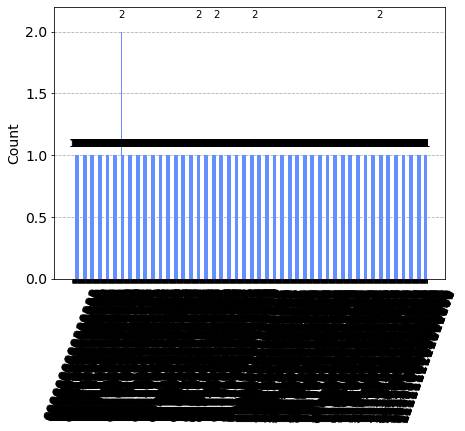

In [10]:
from qiskit.visualization import plot_histogram

qc_result = create_qaoa_circ(Ising_coeff, theta)
counts = backend.run(qc_result).result().get_counts()

plot_histogram(counts)

In [19]:
def find_min_config(counts):
    h = 1000000
    config = ''
    for (bitstring, h) in counts.items():
        H = H_Ising(bitstring, Ising_coeff)
        if H < h:
            config = bitstring
            h = H

    
    return config, h

config_min, h_min = find_min_config(counts)
print("The qubit configuration", config_min, "with minimal value of Hamiltonian =", h_min)

The qubit configuration 1101110001101000 with minimal value of Hamiltonian = -40.52726906832804
